In [1]:
import ROOT
import numpy as np
import glob, os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from skimage.measure import block_reduce
from numpy.lib.stride_tricks import as_strided

def upsample_array(x, b0, b1):

    r, c = x.shape                                    # number of rows/columns
    rs, cs = x.strides                                # row/column strides
    x = as_strided(x, (r, b0, c, b1), (rs, 0, cs, 0)) # view as a larger 4D array

    return x.reshape(r*b0, c*b1)/(b0*b1)              # create new 2D array with same total occupancy

def resample_EE(imgECAL, factor=2):

    # EE-
    imgEEm = imgECAL[:140-85] # EE- in the first 55 rows
    imgEEm = np.pad(imgEEm, ((1,0),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEm_dn = block_reduce(imgEEm, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEm_dn_up = upsample_array(imgEEm_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor**2
    imgECAL[:140-85] = imgEEm_dn_up[1:] ## replace the old EE- rows

    # EE+
    imgEEp = imgECAL[140+85:] # EE+ in the last 55 rows
    imgEEp = np.pad(imgEEp, ((0,1),(0,0)), 'constant', constant_values=0) # for even downsampling, zero pad 55 -> 56
    imgEEp_dn = block_reduce(imgEEp, block_size=(factor, factor), func=np.sum) # downsample by summing over [factor, factor] window
    imgEEp_dn_up = upsample_array(imgEEp_dn, factor, factor)/(factor*factor) # upsample will use same values so need to correct scale by factor*factor
    imgECAL[140+85:] = imgEEp_dn_up[:-1] # replace the old EE+ rows

    return imgECAL

def crop_jet(imgECAL, iphi, ieta, jet_shape=125):

    # NOTE: jet_shape here should correspond to the one used in RHAnalyzer
    off = jet_shape//2
    iphi = int(iphi*5 + 2) # 5 EB xtals per HB tower
    ieta = int(ieta*5 + 2) # 5 EB xtals per HB tower

    # Wrap-around on left side
    if iphi < off:
        diff = off-iphi
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,-diff:],
                                   imgECAL[:,ieta-off:ieta+off+1,:iphi+off+1]), axis=-1)
    # Wrap-around on right side
    elif 360-iphi < off:
        diff = off - (360-iphi)
        img_crop = np.concatenate((imgECAL[:,ieta-off:ieta+off+1,iphi-off:],
                                   imgECAL[:,ieta-off:ieta+off+1,:diff+1]), axis=-1)
    # Nominal case
    else:
        img_crop = imgECAL[:,ieta-off:ieta+off+1,iphi-off:iphi+off+1]

    return img_crop



Welcome to JupyROOT 6.26/10


In [2]:
!ls data

BoostedTop_x1_fixed_4.snappy.parquet
HIG_RunIISummer20UL18_HtoAAto4tau_massregression_v5.parquet.1
HIG_RunIISummer20UL18_HtoAAto4tau_mr.parquet.1
HIG_RunIISummer20UL18_HtoAAto4tau_mr_full.parquet.1
HIG_RunIISummer20UL18_HtoAAto4tau_mr_unmerged.parquet.1
HIG_RunIISummer20UL18_HtoAAto4tau_mr_v2.parquet.1
HIG_RunIISummer20UL18_HtoAAto4tau_v5.parquet.15
HToTauTau_Hadronic_RHAnalyzer_M12_part1.parquet
H_AA_4Tau_M10_merged_ntuples.root
H_AA_4Tau_M10_merged_withPU_ntuples.root
H_AA_4Tau_M10_merged_withoutPU_ntuples.root
H_AA_4tau_merged_withoutPU_ntuples.root
H_AA_from_davide.root
H_TauTau_merges_output.root
HtoTauTau_unmerged_output_numEvent10.root
HtoaaTo4tau_merged_output_numEvent10
IMG_aToTauTau_ML.parquet.100
Upsilon1SToTauTau_13TeV_TuneCUETP8M1.parquet.454
Upsilon1SToTauTau_ntuple_99.root
UpsilonToTauTau_validation_output.root
aToTauTau_ML_root_Ntuples
aToTauTau_noAnitipar_output_99.root
aToTauTau_noAnitipar_output_numEvent20.root
aToTauTau_ntuples_output.root
aToTauTau_output_numEvent1

### For unmerged H->TauTau

### For H->AA->4Tau withPU

In [1]:
def plotJet(img, mins, maxs, eve):
    out_dir='plot_for_prelim/Img_H_AA_4Tau'
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    plt.title(f"Full Image event number {eve}", size=30)
    plt.xlabel(r"$\mathrm{i\varphi}$", size=30) #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$", size=30) #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
#     plt.savefig(f'{out_dir}/{eve}_Full_Image_event.png',facecolor='w',dpi=300)
    plt.show()
    
def plotJet_crop(img, mins, maxs, eve, crop_position):
    out_dir='plot_for_prelim/Img_H_AA_4Tau'
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    plt.title(f"Cropped Image event number {eve} at position {crop_position}", size=25)
    plt.xlabel(r"$\mathrm{i\varphi}$", size=30) #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$", size=30) #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
#     plt.savefig(f'{out_dir}/{eve}_Cropped_Image_event_crop_{crop_position}.png',facecolor='w',dpi=300)
    plt.show()

    
rhTreeStr = "data/H_AA_4Tau_M10_merged_withPU_ntuples.root"
rhTree = ROOT.TChain("fevt/RHTree")
rhTree.Add(rhTreeStr)
nEvts = rhTree.GetEntries()
assert nEvts > 0
print (" >> Input file:",rhTreeStr)
print (" >> nEvts:",nEvts)




# Event range to process
iEvtStart = 0
# iEvtEnd   = 2
iEvtEnd   = nEvts
assert iEvtEnd <= nEvts
print (" >> Processing entries: [",iEvtStart,"->",iEvtEnd,")")
nJets = 0
data = {} # Arrays to be written to parquet should be saved to data dict
total = 0;

for iEvt in range(iEvtStart,iEvtEnd):
    # Initialize event
    rhTree.GetEntry(iEvt)
    ECAL_energy = np.array(rhTree.ECAL_energy).reshape(280,360)
    ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy = np.array(rhTree.HBHE_energy).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
    TracksAtECAL_pt    = np.array(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
    TracksAtECAL_dZSig = np.array(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
    PixAtEcal_1        = np.array(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
    PixAtEcal_2        = np.array(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
    PixAtEcal_3        = np.array(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
    PixAtEcal_4        = np.array(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
    TibAtEcal_1        = np.array(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
    TibAtEcal_2        = np.array(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
    TibAtEcal_3        = np.array(rhTree.TIB_layer3_ECAL_atPV).reshape(280,360)
    TibAtEcal_4        = np.array(rhTree.TIB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_1        = np.array(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
    TobAtEcal_2        = np.array(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
    TobAtEcal_3        = np.array(rhTree.TOB_layer3_ECAL_atPV).reshape(280,360)
    TobAtEcal_4        = np.array(rhTree.TOB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_5        = np.array(rhTree.TOB_layer5_ECAL_atPV).reshape(280,360)
    TobAtEcal_6        = np.array(rhTree.TOB_layer6_ECAL_atPV).reshape(280,360)
    TecAtEcal_1        = np.array(rhTree.TEC_layer1_ECAL_atPV).reshape(280,360)
    TecAtEcal_2        = np.array(rhTree.TEC_layer2_ECAL_atPV).reshape(280,360)
    TecAtEcal_3        = np.array(rhTree.TEC_layer3_ECAL_atPV).reshape(280,360)
    TidAtEcal_1        = np.array(rhTree.TID_layer1_ECAL_atPV).reshape(280,360)

#     X_CMS         = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy], axis=0)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1, TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1, TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    data['X_jet_full'] = X_CMS
    
    img_full = data['X_jet_full']
    mins = [0.00001]*23
    
    maxs =[]
    for i in range(23):
        maxs.append(img_full[i].max())
    
    
    # Jet attributes
    ys     = rhTree.jetIsSignal
    iphis  = rhTree.jetSeed_iphi
    ietas  = rhTree.jetSeed_ieta
#     aetas   = rhTree.a_eta
#     aphis   = rhTree.a_phi
#     taudRs = rhTree.TaudR
#     dRs    = rhTree.jetadR
#     pts    = rhTree.jetPt
#     m0s    = rhTree.jetM
    njets  = len(ys)
    plotJet(img_full, mins, maxs, iEvt)
    for i in range(njets):
#         data['aeta']   = aetas[i]
#         data['aphi']   = aphis[i]
#         data['taudR'] = taudRs[i]
#         data['dR']    = dRs[i]
#         data['pt']    = pts[i]
#         data['m0']    = m0s[i]
        data['iphi']  = iphis[i]
        data['ieta']  = ietas[i]
        data['X_jet'] = crop_jet(X_CMS , data['iphi'], data['ieta'])  # (23, 125, 125)
        img_cropped = data['X_jet']
        maxs =[]
        for j in range(23):
            maxs.append(img_cropped[j].max())
        plotJet_crop(img_cropped, mins, maxs, iEvt, i+1)
        
# print("full jet size. ", data['X_jet_full'].shape,"croped size. ", data['X_jet'].shape)




NameError: name 'ROOT' is not defined

### Single layer Images

 >> Input file: data/H_AA_4Tau_M10_merged_withPU_ntuples.root
 >> nEvts: 5
 >> Processing entries: [ 0 -> 5 )


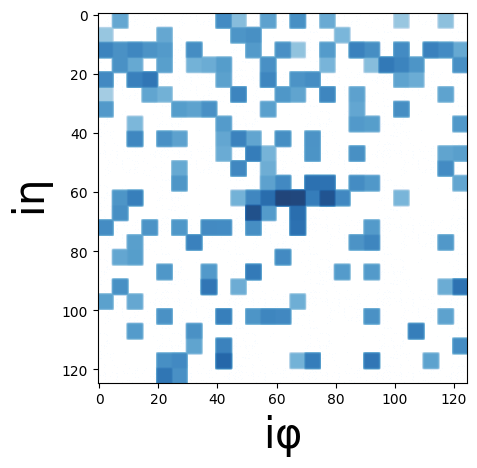

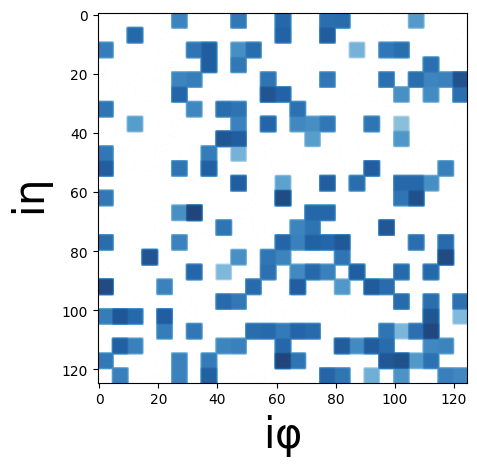

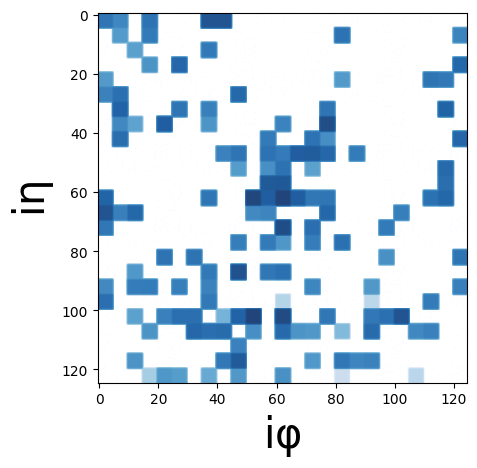

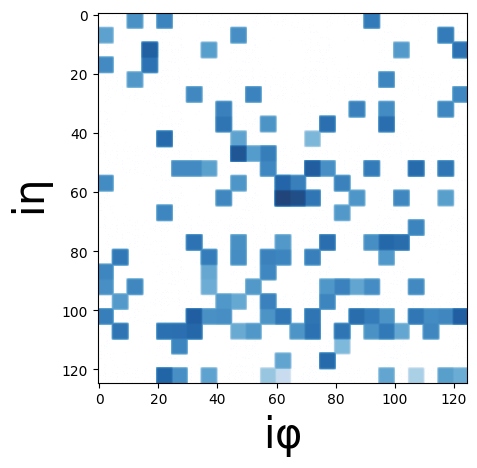

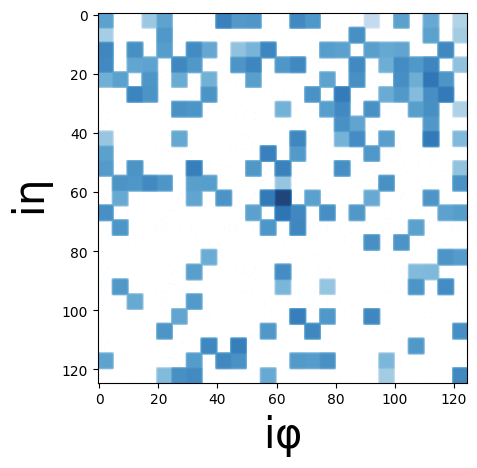

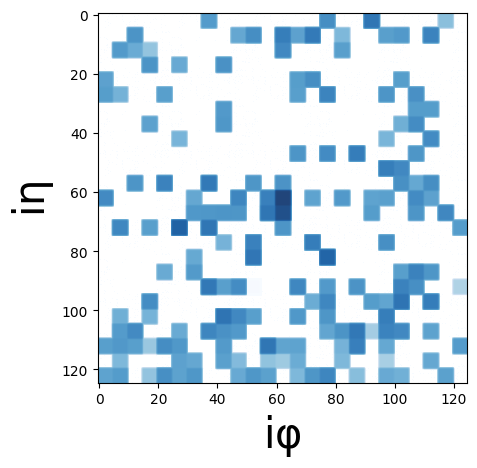

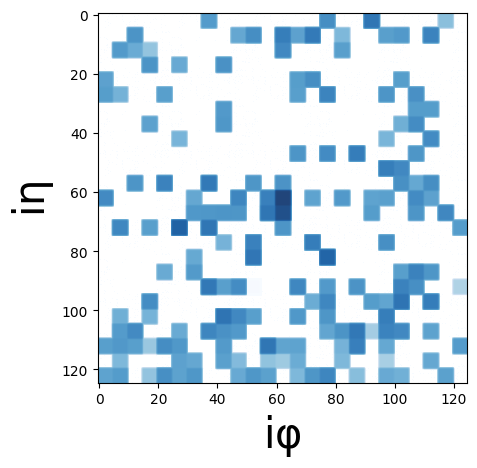

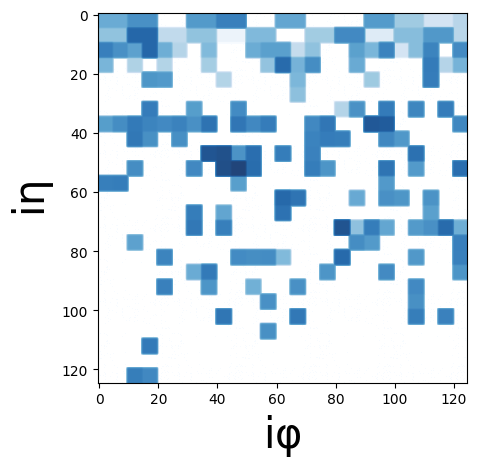

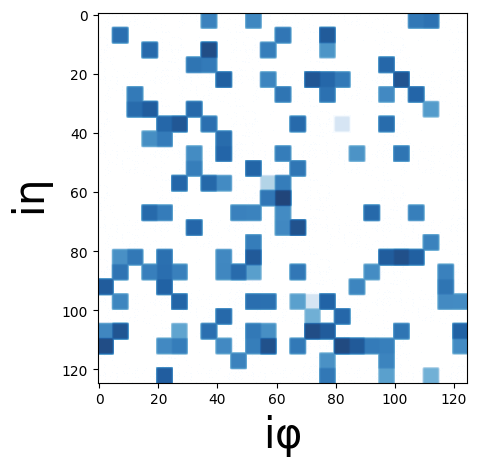

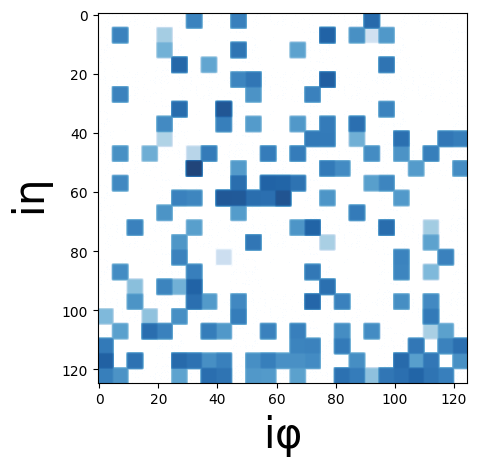

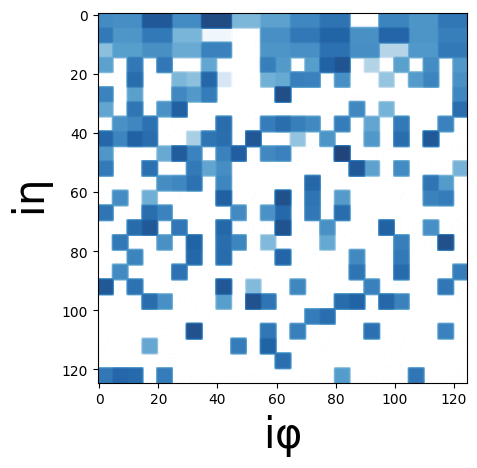

In [12]:
def plotJet_crop(img, mins, maxs, eve, crop_position):
    out_dir='plot_for_prelim'
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
#     if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
#     if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
#     if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
#     if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.9)   
#     if maxs[5]  > 0 : plt.imshow(img[5], cmap='Oranges', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
#     if maxs[10] > 0 : plt.imshow(img[10], cmap= 'Oranges',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
#     plt.title(f"Cropped Image event number {eve} at position {crop_position}, dR = {dR}", size=25)
    plt.xlabel(r"$\mathrm{i\varphi}$", size=30) #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$", size=30) #28, 30
    #LEGEND
#     colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
#     labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
#     patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
#     plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
    plt.savefig(f'{out_dir}/pixel_1_{eve}_{crop_position}.png',facecolor='w',dpi=300)
    plt.show()

    
rhTreeStr = "data/H_AA_4Tau_M10_merged_withPU_ntuples.root"
rhTree = ROOT.TChain("fevt/RHTree")
rhTree.Add(rhTreeStr)
nEvts = rhTree.GetEntries()
assert nEvts > 0
print (" >> Input file:",rhTreeStr)
print (" >> nEvts:",nEvts)




# Event range to process
iEvtStart = 0
# iEvtEnd   = 4
iEvtEnd   = nEvts
assert iEvtEnd <= nEvts
print (" >> Processing entries: [",iEvtStart,"->",iEvtEnd,")")
nJets = 0
data = {} # Arrays to be written to parquet should be saved to data dict
total = 0;

for iEvt in range(iEvtStart,iEvtEnd):
    # Initialize event
    rhTree.GetEntry(iEvt)
    ECAL_energy = np.array(rhTree.ECAL_energy).reshape(280,360)
    ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy = np.array(rhTree.HBHE_energy).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
    TracksAtECAL_pt    = np.array(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
    TracksAtECAL_dZSig = np.array(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
    PixAtEcal_1        = np.array(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
    PixAtEcal_2        = np.array(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
    PixAtEcal_3        = np.array(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
    PixAtEcal_4        = np.array(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
    TibAtEcal_1        = np.array(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
    TibAtEcal_2        = np.array(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
    TibAtEcal_3        = np.array(rhTree.TIB_layer3_ECAL_atPV).reshape(280,360)
    TibAtEcal_4        = np.array(rhTree.TIB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_1        = np.array(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
    TobAtEcal_2        = np.array(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
    TobAtEcal_3        = np.array(rhTree.TOB_layer3_ECAL_atPV).reshape(280,360)
    TobAtEcal_4        = np.array(rhTree.TOB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_5        = np.array(rhTree.TOB_layer5_ECAL_atPV).reshape(280,360)
    TobAtEcal_6        = np.array(rhTree.TOB_layer6_ECAL_atPV).reshape(280,360)
    TecAtEcal_1        = np.array(rhTree.TEC_layer1_ECAL_atPV).reshape(280,360)
    TecAtEcal_2        = np.array(rhTree.TEC_layer2_ECAL_atPV).reshape(280,360)
    TecAtEcal_3        = np.array(rhTree.TEC_layer3_ECAL_atPV).reshape(280,360)
    TidAtEcal_1        = np.array(rhTree.TID_layer1_ECAL_atPV).reshape(280,360)

#     X_CMS         = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy], axis=0)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1, TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1, TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    data['X_jet_full'] = X_CMS
    
    img_full = data['X_jet_full']
    mins = [0.00001]*23
    
#     maxs =[]
#     for i in range(23):
#         maxs.append(img_full[i].max())
    
    
    # Jet attributes
    ys     = rhTree.jetIsSignal
    iphis  = rhTree.jetSeed_iphi
    ietas  = rhTree.jetSeed_ieta
#     aetas   = rhTree.a_eta
#     aphis   = rhTree.a_phi
#     taudRs = rhTree.TaudR
#     dRs    = rhTree.jetadR
#     pts    = rhTree.jetPt
#     m0s    = rhTree.jetM
    njets  = len(ys)
#     plotJet(img_full, mins, maxs, iEvt)
    for i in range(njets):
#         data['aeta']   = aetas[i]
#         data['aphi']   = aphis[i]
#         data['taudR'] = taudRs[i]
#         data['dR']    = dRs[i]
#         data['pt']    = pts[i]
#         data['m0']    = m0s[i]
        data['iphi']  = iphis[i]
        data['ieta']  = ietas[i]
        data['X_jet'] = crop_jet(X_CMS , data['iphi'], data['ieta'])  # (23, 125, 125)
        img_cropped = data['X_jet']
        maxs =[]
        for j in range(23):
            maxs.append(img_cropped[j].max())
        plotJet_crop(img_cropped, mins, maxs, iEvt, i+1)

### H --> AA --> 4Tau merged without PU

 >> Input file: data/H_AA_4Tau_M10_merged_withoutPU_ntuples.root
 >> nEvts: 8
 >> Processing entries: [ 0 -> 8 )


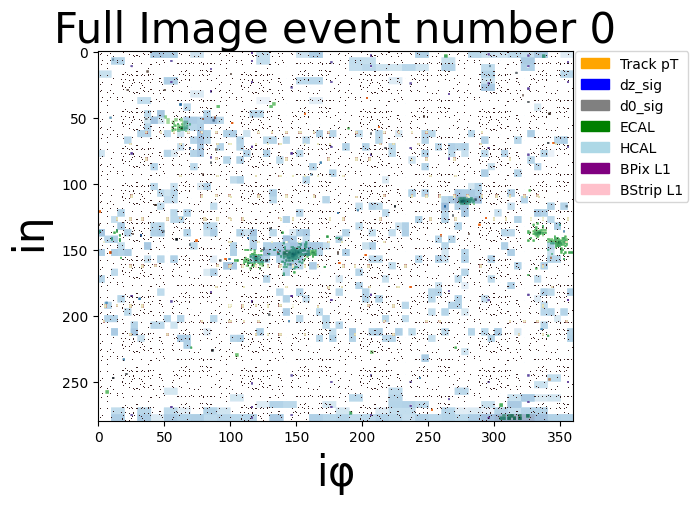

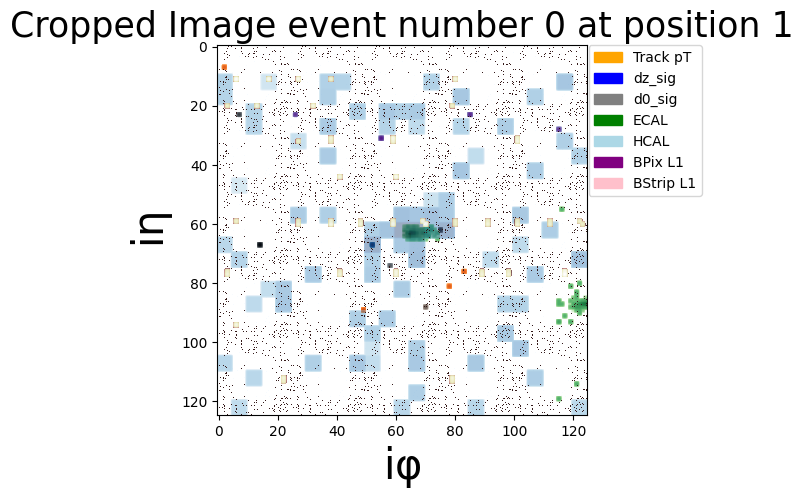

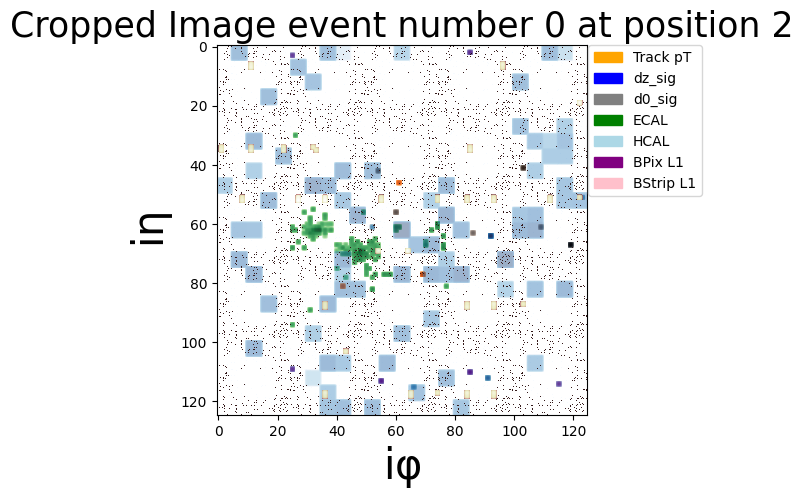

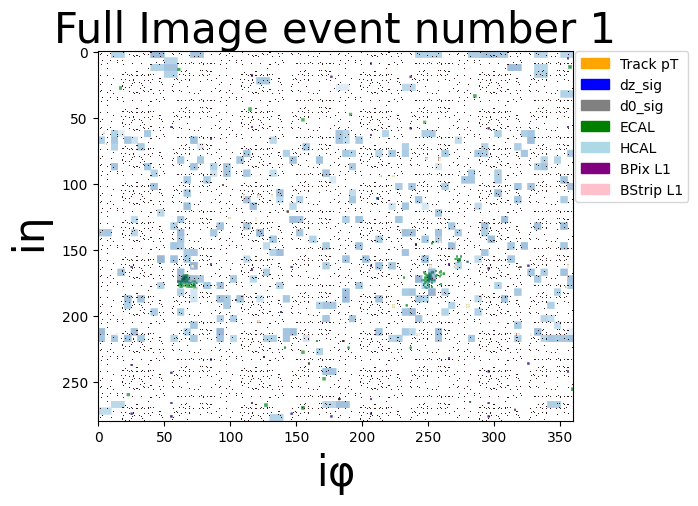

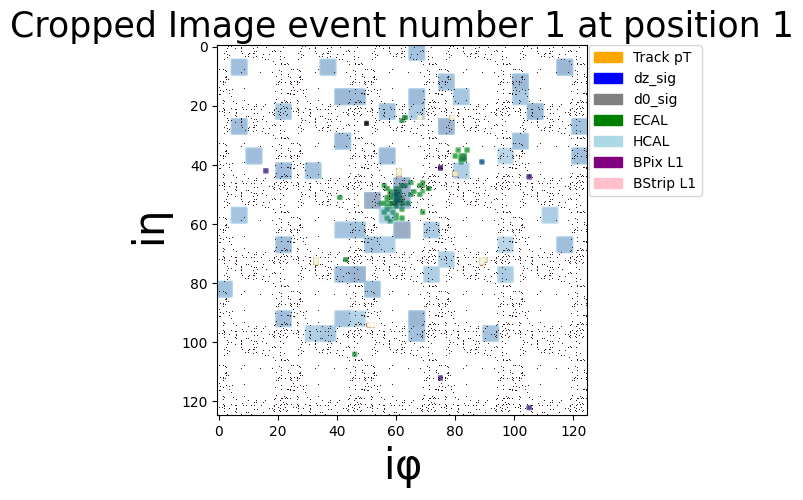

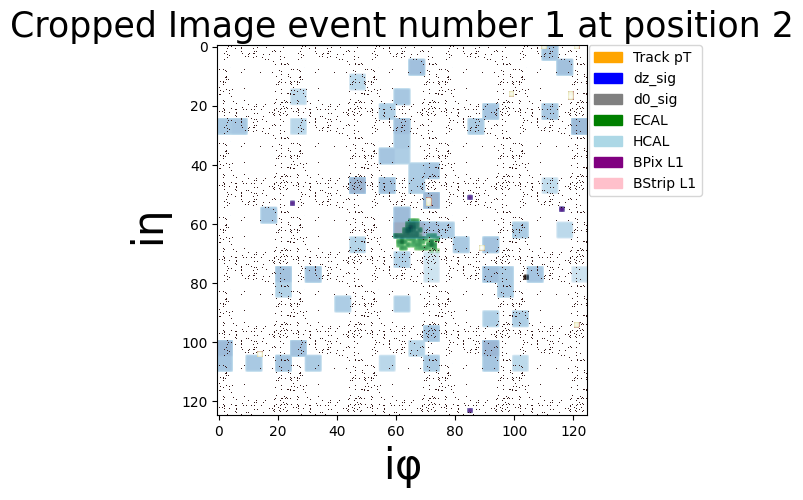

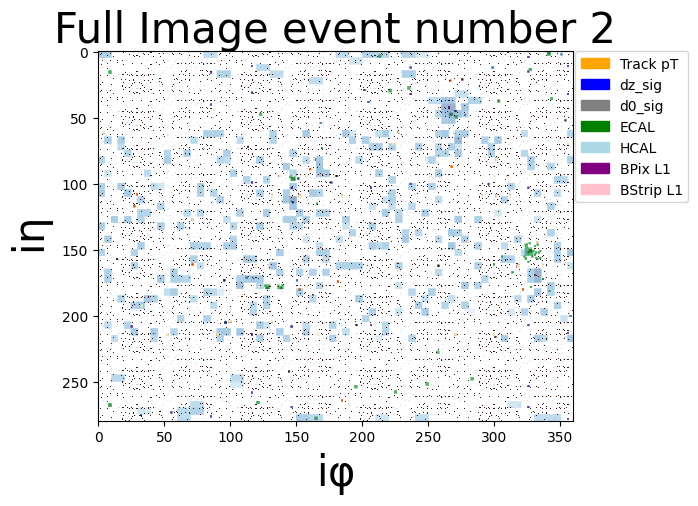

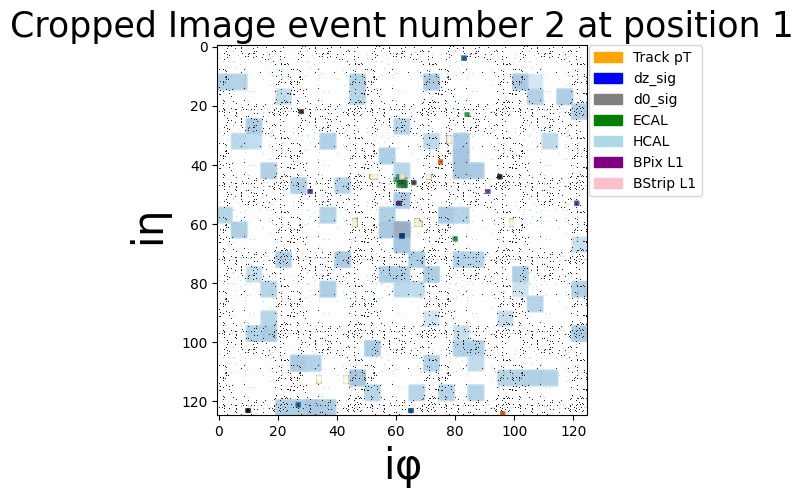

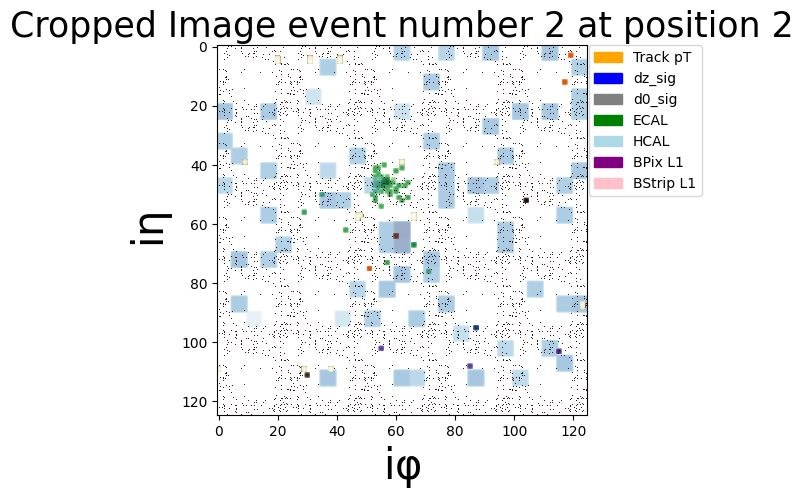

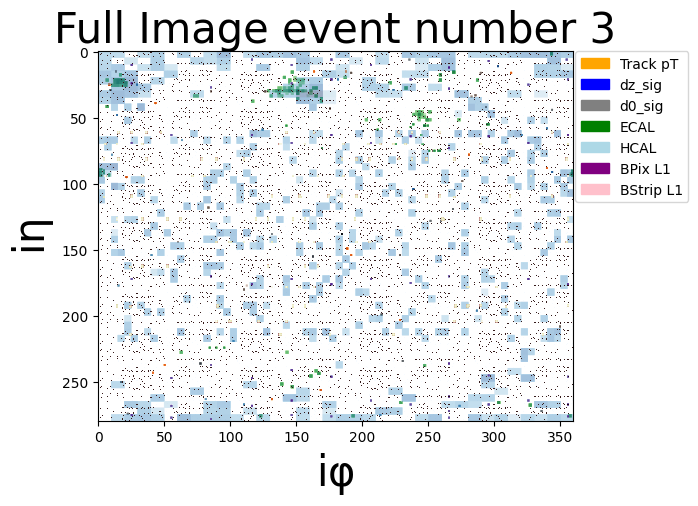

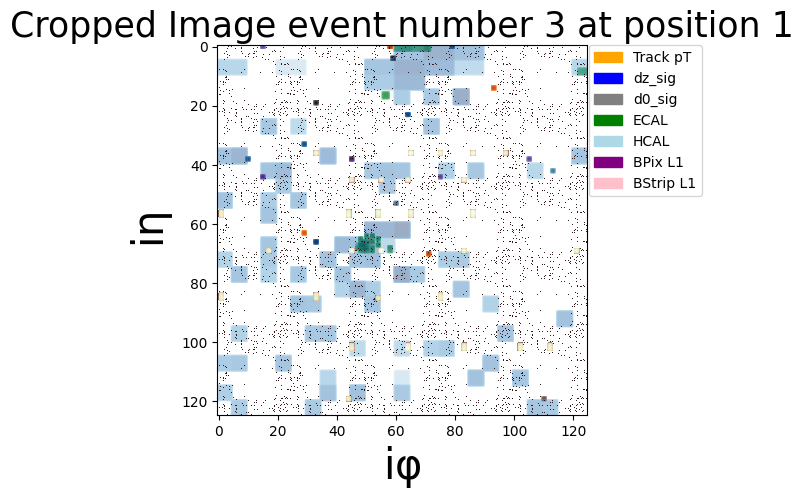

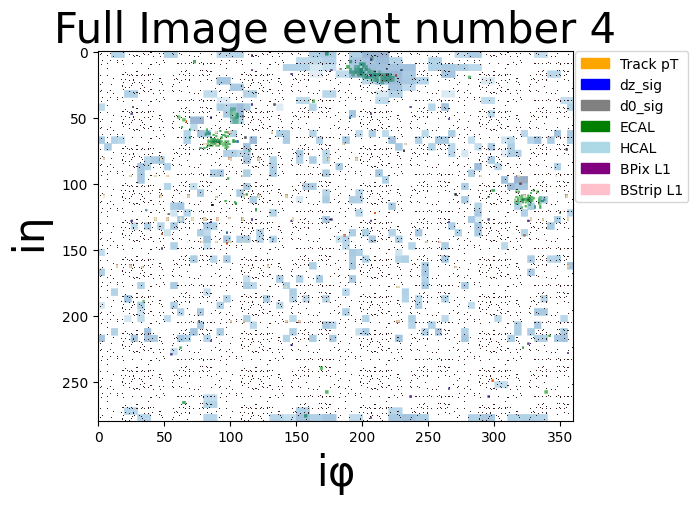

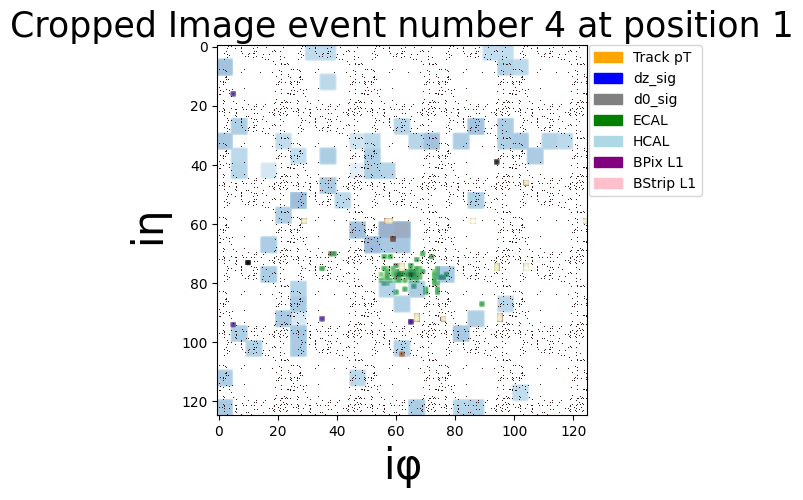

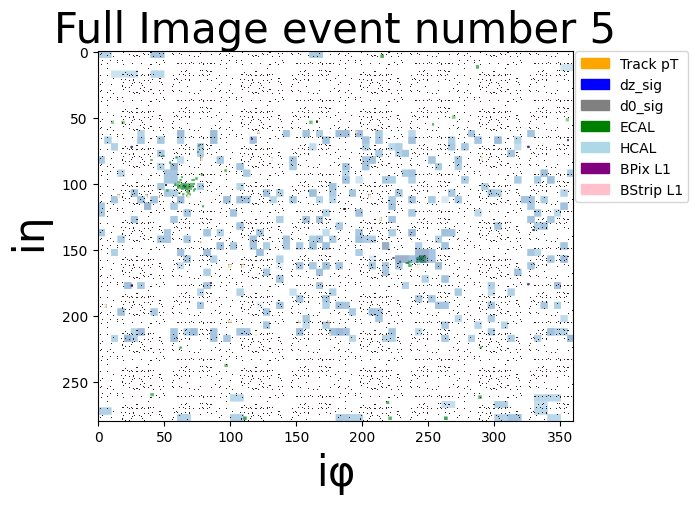

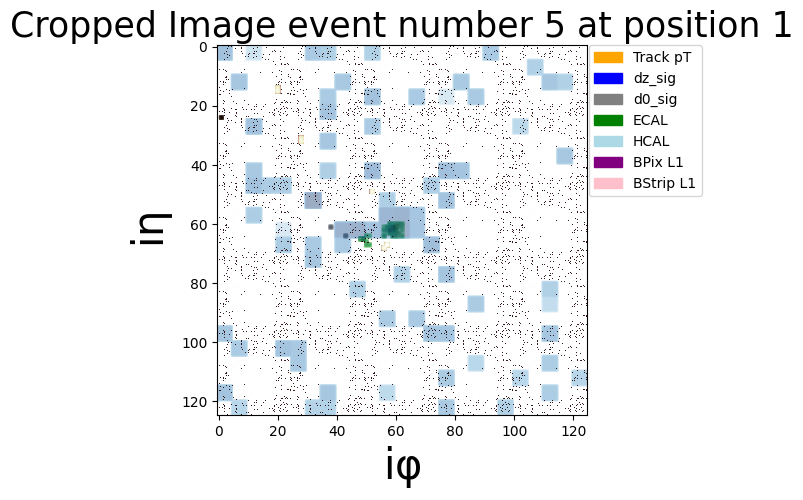

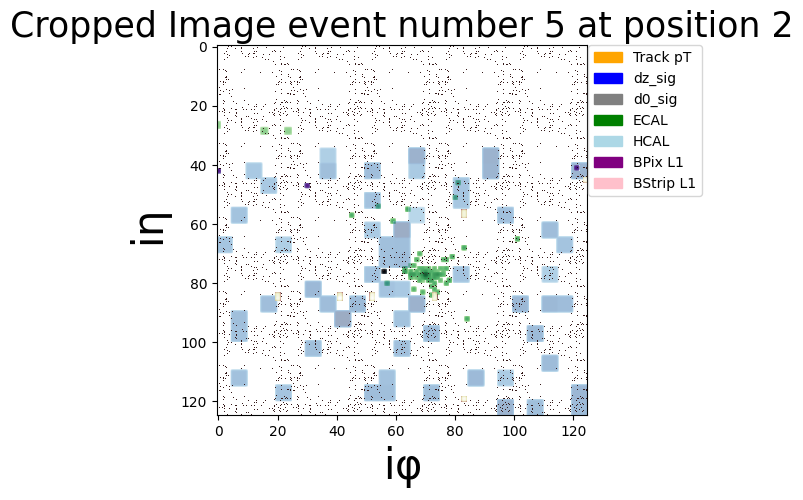

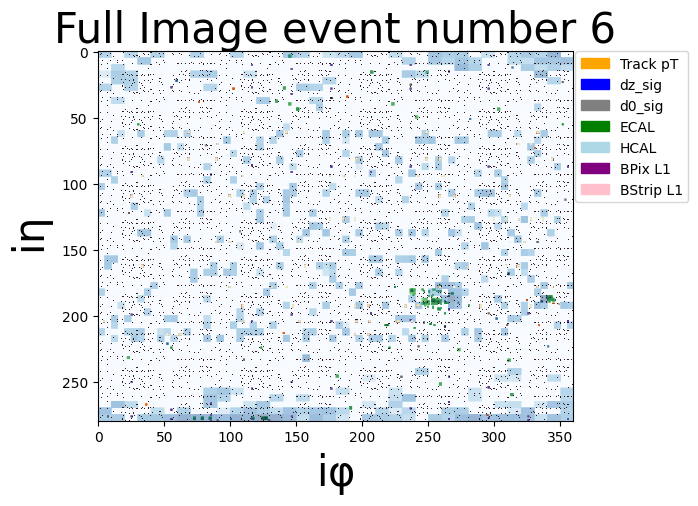

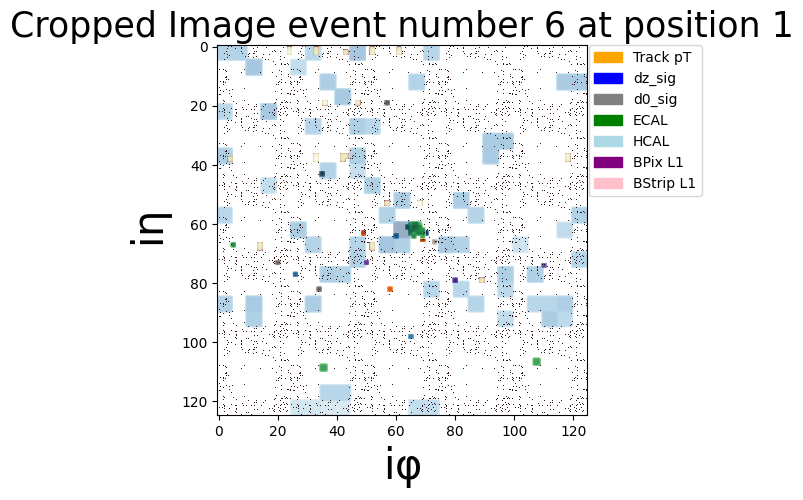

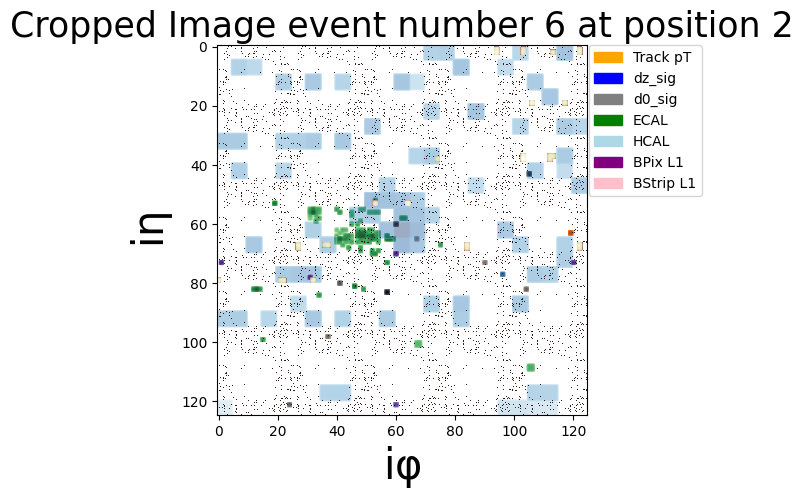

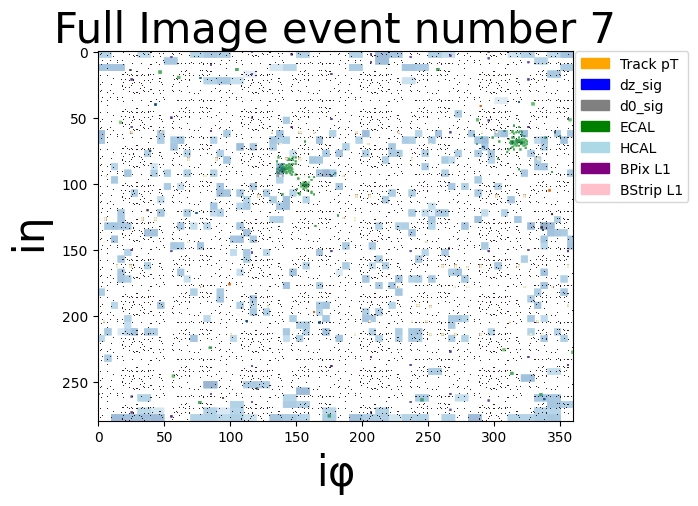

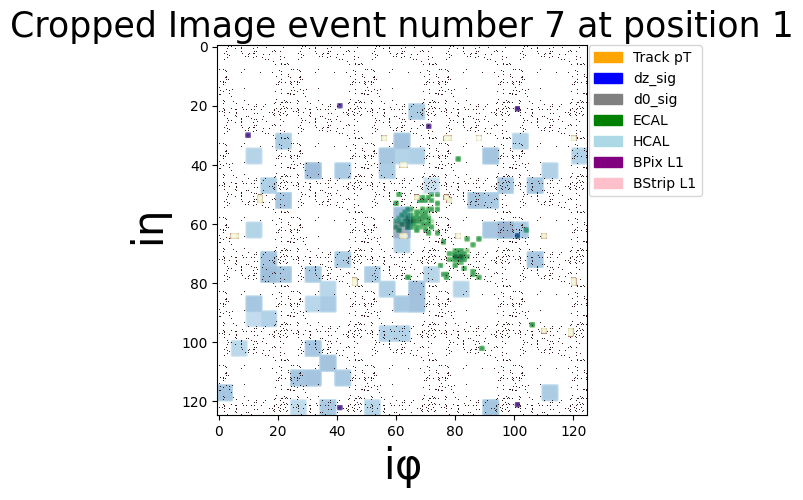

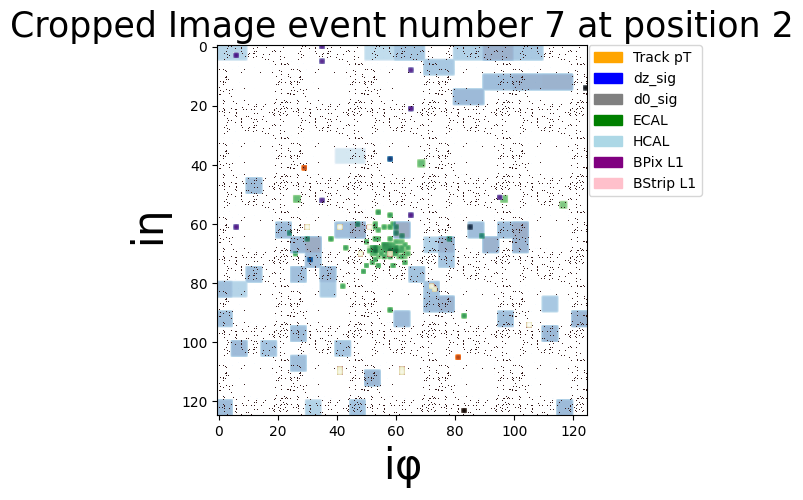

In [9]:
def plotJet(img, mins, maxs, eve):
    out_dir='plot_for_prelim/Img_H_AA_4Tau'
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    plt.title(f"Full Image event number {eve}", size=30)
    plt.xlabel(r"$\mathrm{i\varphi}$", size=30) #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$", size=30) #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
#     plt.savefig(f'{out_dir}/{eve}_Full_Image_event.png',facecolor='w',dpi=300)
    plt.show()
    
def plotJet_crop(img, mins, maxs, eve, crop_position):
    out_dir='plot_for_prelim/Img_H_AA_4Tau'
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
    if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
    if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
    if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.4)   
    if maxs[5]  > 0 : plt.imshow(img[5], cmap='Purples', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
    if maxs[10] > 0 : plt.imshow(img[10], cmap= 'pink',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
    plt.title(f"Cropped Image event number {eve} at position {crop_position}", size=25)
    plt.xlabel(r"$\mathrm{i\varphi}$", size=30) #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$", size=30) #28, 30
    #LEGEND
    colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
    labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
    patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
    plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
#     plt.savefig(f'{out_dir}/{eve}_Cropped_Image_event_crop_{crop_position}.png',facecolor='w',dpi=300)
    plt.show()

    
rhTreeStr = "data/H_AA_4Tau_M10_merged_withoutPU_ntuples.root"
rhTree = ROOT.TChain("fevt/RHTree")
rhTree.Add(rhTreeStr)
nEvts = rhTree.GetEntries()
assert nEvts > 0
print (" >> Input file:",rhTreeStr)
print (" >> nEvts:",nEvts)




# Event range to process
iEvtStart = 0
# iEvtEnd   = 2
iEvtEnd   = nEvts
assert iEvtEnd <= nEvts
print (" >> Processing entries: [",iEvtStart,"->",iEvtEnd,")")
nJets = 0
data = {} # Arrays to be written to parquet should be saved to data dict
total = 0;

for iEvt in range(iEvtStart,iEvtEnd):
    # Initialize event
    rhTree.GetEntry(iEvt)
    ECAL_energy = np.array(rhTree.ECAL_energy).reshape(280,360)
    ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy = np.array(rhTree.HBHE_energy).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
    TracksAtECAL_pt    = np.array(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
    TracksAtECAL_dZSig = np.array(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
    PixAtEcal_1        = np.array(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
    PixAtEcal_2        = np.array(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
    PixAtEcal_3        = np.array(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
    PixAtEcal_4        = np.array(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
    TibAtEcal_1        = np.array(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
    TibAtEcal_2        = np.array(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
    TibAtEcal_3        = np.array(rhTree.TIB_layer3_ECAL_atPV).reshape(280,360)
    TibAtEcal_4        = np.array(rhTree.TIB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_1        = np.array(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
    TobAtEcal_2        = np.array(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
    TobAtEcal_3        = np.array(rhTree.TOB_layer3_ECAL_atPV).reshape(280,360)
    TobAtEcal_4        = np.array(rhTree.TOB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_5        = np.array(rhTree.TOB_layer5_ECAL_atPV).reshape(280,360)
    TobAtEcal_6        = np.array(rhTree.TOB_layer6_ECAL_atPV).reshape(280,360)
    TecAtEcal_1        = np.array(rhTree.TEC_layer1_ECAL_atPV).reshape(280,360)
    TecAtEcal_2        = np.array(rhTree.TEC_layer2_ECAL_atPV).reshape(280,360)
    TecAtEcal_3        = np.array(rhTree.TEC_layer3_ECAL_atPV).reshape(280,360)
    TidAtEcal_1        = np.array(rhTree.TID_layer1_ECAL_atPV).reshape(280,360)

#     X_CMS         = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy], axis=0)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1, TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1, TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    data['X_jet_full'] = X_CMS
    
    img_full = data['X_jet_full']
    mins = [0.00001]*23
    
    maxs =[]
    for i in range(23):
        maxs.append(img_full[i].max())
    
    
    # Jet attributes
    ys     = rhTree.jetIsSignal
    iphis  = rhTree.jetSeed_iphi
    ietas  = rhTree.jetSeed_ieta
#     aetas   = rhTree.a_eta
#     aphis   = rhTree.a_phi
#     taudRs = rhTree.TaudR
#     dRs    = rhTree.jetadR
#     pts    = rhTree.jetPt
#     m0s    = rhTree.jetM
    njets  = len(ys)
    plotJet(img_full, mins, maxs, iEvt)
    for i in range(njets):
#         data['aeta']   = aetas[i]
#         data['aphi']   = aphis[i]
#         data['taudR'] = taudRs[i]
#         data['dR']    = dRs[i]
#         data['pt']    = pts[i]
#         data['m0']    = m0s[i]
        data['iphi']  = iphis[i]
        data['ieta']  = ietas[i]
        data['X_jet'] = crop_jet(X_CMS , data['iphi'], data['ieta'])  # (23, 125, 125)
        img_cropped = data['X_jet']
        maxs =[]
        for j in range(23):
            maxs.append(img_cropped[j].max())
        plotJet_crop(img_cropped, mins, maxs, iEvt, i+1)
        
# print("full jet size. ", data['X_jet_full'].shape,"croped size. ", data['X_jet'].shape)




 >> Input file: data/H_AA_4Tau_M10_merged_withoutPU_ntuples.root
 >> nEvts: 8
 >> Processing entries: [ 0 -> 8 )


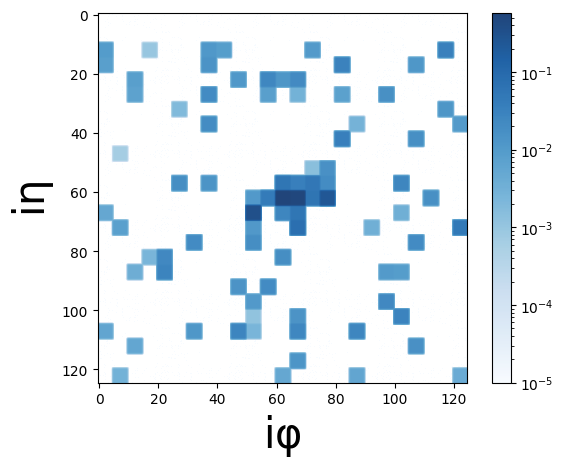

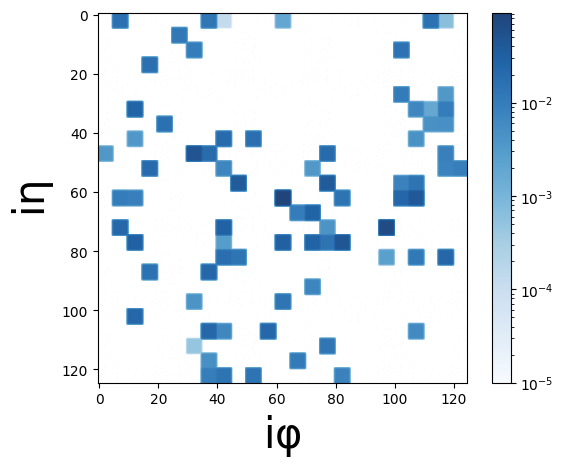

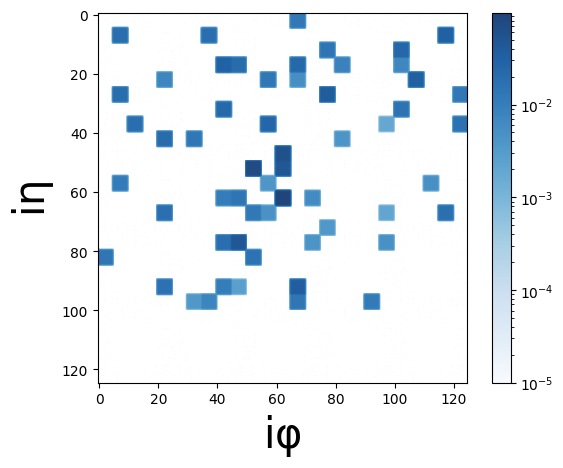

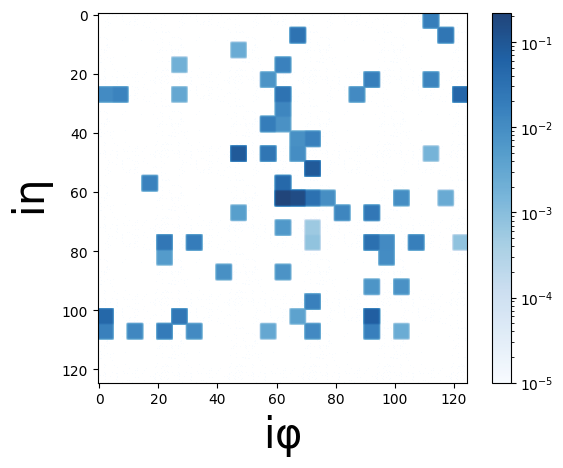

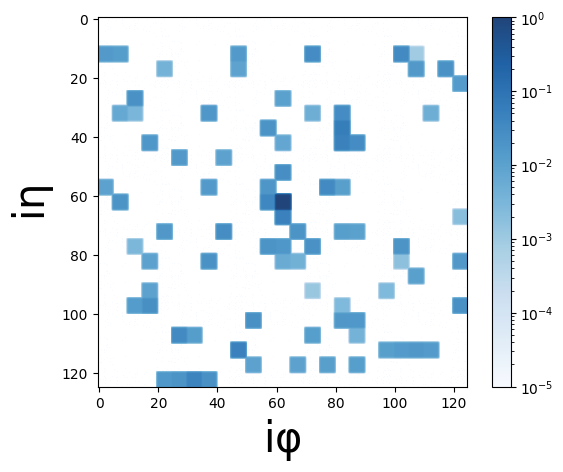

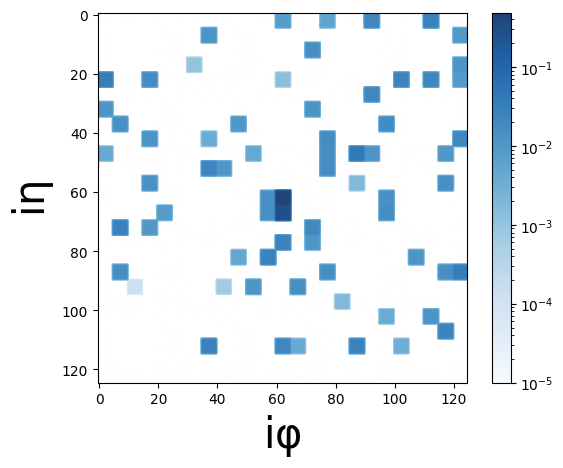

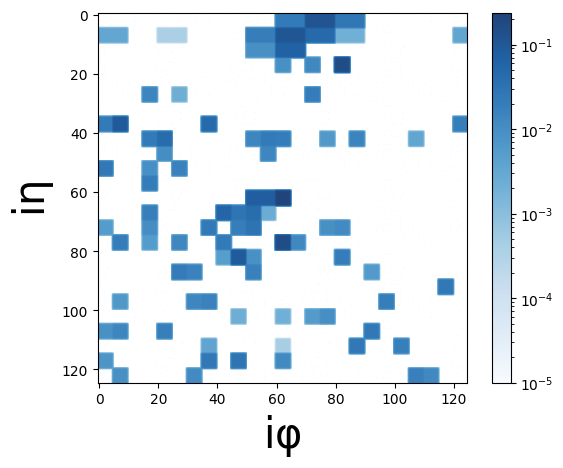

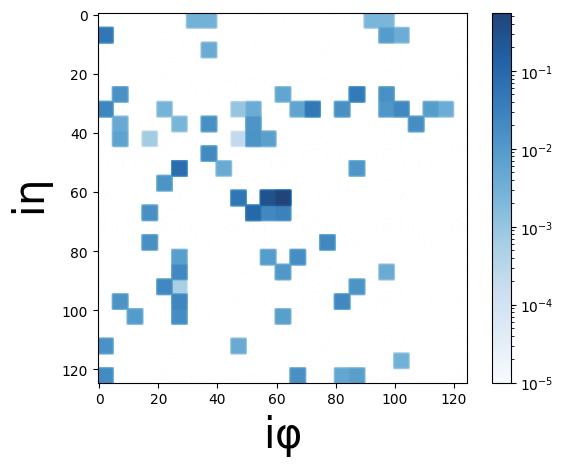

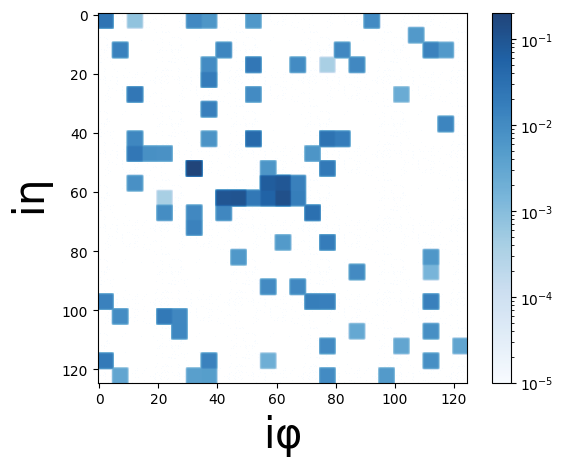

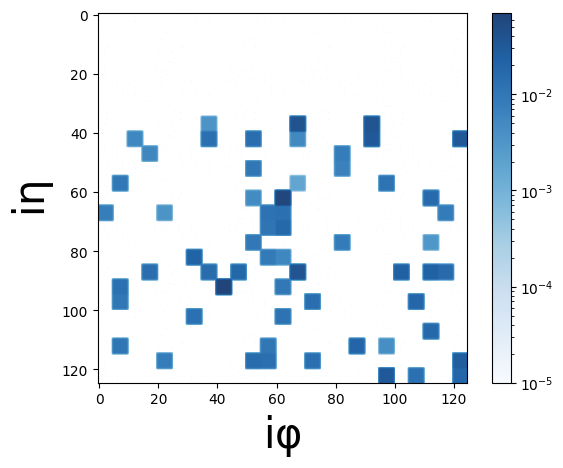

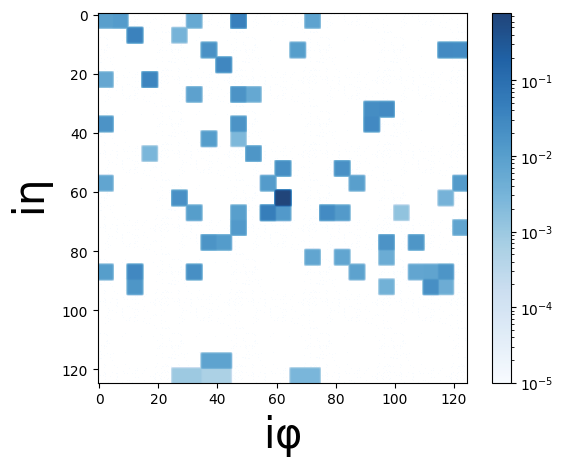

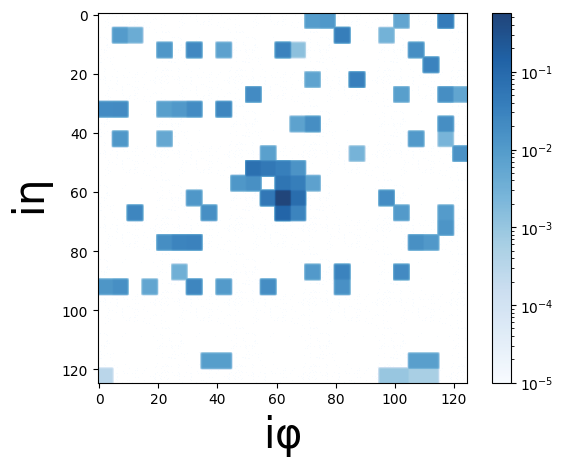

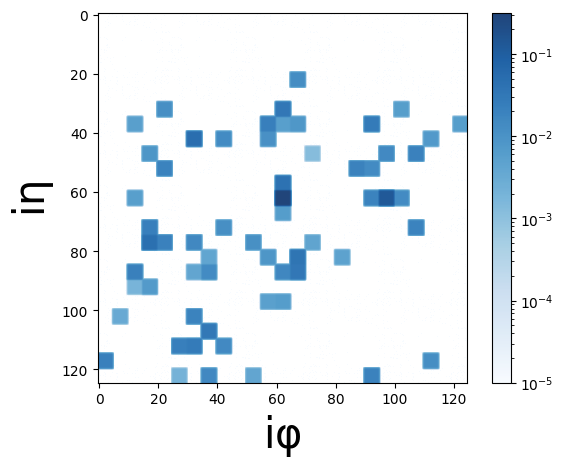

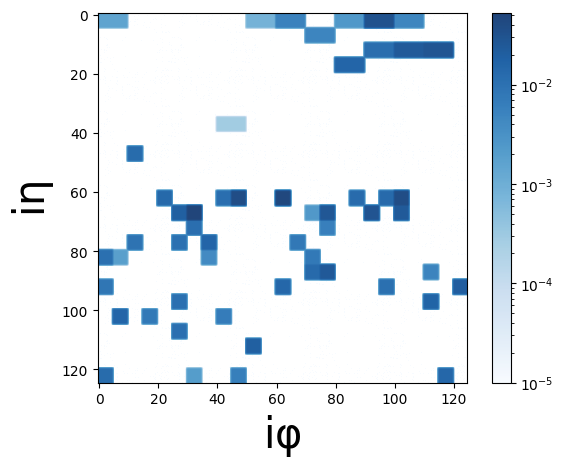

In [16]:
def plotJet_crop(img, mins, maxs, eve, crop_position):
    out_dir='plot_for_prelim'
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
#     if maxs[0]  > 0 : plt.imshow(img[0], cmap='Oranges', norm=LogNorm(vmin=mins[0], vmax=maxs[0]),  alpha=0.9)
#     if maxs[1]  > 0 : plt.imshow(img[1], cmap='Blues',   norm=LogNorm(vmin=mins[1], vmax=maxs[1]),  alpha=0.9)
#     if maxs[2]  > 0 : plt.imshow(img[2], cmap='Greys',   norm=LogNorm(vmin=mins[2], vmax=maxs[2]),  alpha=0.9)
#     if maxs[3]  > 0 : plt.imshow(img[3], cmap='Greens',  norm=LogNorm(vmin=mins[3], vmax=maxs[3]),  alpha=0.9)       
    if maxs[4]  > 0 : plt.imshow(img[4], cmap='Blues',   norm=LogNorm(vmin=mins[4], vmax=maxs[4]),  alpha=0.9)   
#     if maxs[5]  > 0 : plt.imshow(img[5], cmap='Oranges', norm=LogNorm(vmin=mins[5], vmax=maxs[5]),  alpha=0.9)   
#     if maxs[10] > 0 : plt.imshow(img[10], cmap= 'Oranges',  norm=LogNorm(vmin=mins[10],vmax=maxs[10]), alpha=0.9)
#     plt.title(f"Cropped Image event number {eve} at position {crop_position}, dR = {dR}", size=25)
    plt.colorbar()
    plt.xlabel(r"$\mathrm{i\varphi}$", size=30) #28, 30
    plt.ylabel(r"$\mathrm{i\eta}$", size=30) #28, 30
    #LEGEND
#     colors = {0:'orange',1:'blue',2:'grey',3:'green',4:'lightblue',5:'purple',6:'pink'}
#     labels = {0:'Track pT',1:'dz_sig',2:'d0_sig',3:'ECAL',4:'HCAL',5:'BPix L1',6:'BStrip L1'}
#     patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in colors]
#     plt.legend(handles=patches, bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.,fontsize=10 )
    plt.savefig(f'{out_dir}/pixel_1_{eve}_{crop_position}.png',facecolor='w',dpi=300)
    plt.show()

    
rhTreeStr = "data/H_AA_4Tau_M10_merged_withoutPU_ntuples.root"
rhTree = ROOT.TChain("fevt/RHTree")
rhTree.Add(rhTreeStr)
nEvts = rhTree.GetEntries()
assert nEvts > 0
print (" >> Input file:",rhTreeStr)
print (" >> nEvts:",nEvts)




# Event range to process
iEvtStart = 0
# iEvtEnd   = 4
iEvtEnd   = nEvts
assert iEvtEnd <= nEvts
print (" >> Processing entries: [",iEvtStart,"->",iEvtEnd,")")
nJets = 0
data = {} # Arrays to be written to parquet should be saved to data dict
total = 0;

for iEvt in range(iEvtStart,iEvtEnd):
    # Initialize event
    rhTree.GetEntry(iEvt)
    ECAL_energy = np.array(rhTree.ECAL_energy).reshape(280,360)
    ECAL_energy = resample_EE(ECAL_energy)
    HBHE_energy = np.array(rhTree.HBHE_energy).reshape(56,72)
    HBHE_energy = upsample_array(HBHE_energy, 5, 5) # (280, 360)
    TracksAtECAL_pt    = np.array(rhTree.ECAL_tracksPt_atECALfixIP).reshape(280,360)
    TracksAtECAL_dZSig = np.array(rhTree.ECAL_tracksDzSig_atECALfixIP).reshape(280,360)
    TracksAtECAL_d0Sig = np.array(rhTree.ECAL_tracksD0Sig_atECALfixIP).reshape(280,360)
    PixAtEcal_1        = np.array(rhTree.BPIX_layer1_ECAL_atPV).reshape(280,360)
    PixAtEcal_2        = np.array(rhTree.BPIX_layer2_ECAL_atPV).reshape(280,360)
    PixAtEcal_3        = np.array(rhTree.BPIX_layer3_ECAL_atPV).reshape(280,360)
    PixAtEcal_4        = np.array(rhTree.BPIX_layer4_ECAL_atPV).reshape(280,360)
    TibAtEcal_1        = np.array(rhTree.TIB_layer1_ECAL_atPV).reshape(280,360)
    TibAtEcal_2        = np.array(rhTree.TIB_layer2_ECAL_atPV).reshape(280,360)
    TibAtEcal_3        = np.array(rhTree.TIB_layer3_ECAL_atPV).reshape(280,360)
    TibAtEcal_4        = np.array(rhTree.TIB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_1        = np.array(rhTree.TOB_layer1_ECAL_atPV).reshape(280,360)
    TobAtEcal_2        = np.array(rhTree.TOB_layer2_ECAL_atPV).reshape(280,360)
    TobAtEcal_3        = np.array(rhTree.TOB_layer3_ECAL_atPV).reshape(280,360)
    TobAtEcal_4        = np.array(rhTree.TOB_layer4_ECAL_atPV).reshape(280,360)
    TobAtEcal_5        = np.array(rhTree.TOB_layer5_ECAL_atPV).reshape(280,360)
    TobAtEcal_6        = np.array(rhTree.TOB_layer6_ECAL_atPV).reshape(280,360)
    TecAtEcal_1        = np.array(rhTree.TEC_layer1_ECAL_atPV).reshape(280,360)
    TecAtEcal_2        = np.array(rhTree.TEC_layer2_ECAL_atPV).reshape(280,360)
    TecAtEcal_3        = np.array(rhTree.TEC_layer3_ECAL_atPV).reshape(280,360)
    TidAtEcal_1        = np.array(rhTree.TID_layer1_ECAL_atPV).reshape(280,360)

#     X_CMS         = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy], axis=0)
    X_CMS             = np.stack([TracksAtECAL_pt, TracksAtECAL_dZSig, TracksAtECAL_d0Sig, ECAL_energy, HBHE_energy, PixAtEcal_1,
    PixAtEcal_2, PixAtEcal_3, PixAtEcal_4, TibAtEcal_1, TibAtEcal_2, TibAtEcal_3, TibAtEcal_4, TobAtEcal_1, TobAtEcal_2, TobAtEcal_3, TobAtEcal_4, TobAtEcal_5, TobAtEcal_6, TidAtEcal_1, TecAtEcal_1, TecAtEcal_2, TecAtEcal_3], axis=0) # (23, 280, 360)
    data['X_jet_full'] = X_CMS
    
    img_full = data['X_jet_full']
    mins = [0.00001]*23
    
#     maxs =[]
#     for i in range(23):
#         maxs.append(img_full[i].max())
    
    
    # Jet attributes
    ys     = rhTree.jetIsSignal
    iphis  = rhTree.jetSeed_iphi
    ietas  = rhTree.jetSeed_ieta
#     aetas   = rhTree.a_eta
#     aphis   = rhTree.a_phi
#     taudRs = rhTree.TaudR
#     dRs    = rhTree.jetadR
#     pts    = rhTree.jetPt
#     m0s    = rhTree.jetM
    njets  = len(ys)
#     plotJet(img_full, mins, maxs, iEvt)
    for i in range(njets):
#         data['aeta']   = aetas[i]
#         data['aphi']   = aphis[i]
#         data['taudR'] = taudRs[i]
#         data['dR']    = dRs[i]
#         data['pt']    = pts[i]
#         data['m0']    = m0s[i]
        data['iphi']  = iphis[i]
        data['ieta']  = ietas[i]
        data['X_jet'] = crop_jet(X_CMS , data['iphi'], data['ieta'])  # (23, 125, 125)
        img_cropped = data['X_jet']
        maxs =[]
        for j in range(23):
            maxs.append(img_cropped[j].max())
        plotJet_crop(img_cropped, mins, maxs, iEvt, i+1)